In [2]:
import pandas as pd
from gensim.models import Word2Vec,LdaModel,TfidfModel
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter,OrderedDict,defaultdict

In [2]:
wd_data=pd.read_parquet('data\patent_cut_doc.parquet')
wd_data.head()

,序号,词语
0,123,"[竖式, 烧结, 冷却, 一种, 具有, 环形, 风道, 密闭, 结构, 竖式, 烧结, 冷..."
1,142,"[具有, 抗静电, 轻垢, 液体, 洗衣, 洗涤剂, 提供, 一种, 透明, 半透明, 具有..."
2,154,"[麦白, 霉素, 胃溶片, 生产工艺, 技术, 一种, 麦白, 霉素, 胃溶片, 生产工艺,..."
3,160,"[药品, 包装盒, 省略, 视图]"
4,165,"[变幅, 摇头, 电风扇, 一种, 变幅, 摇头, 电风扇, 包括, 扇体, 扇体, 变幅,..."


In [3]:
wd_data['词语']=wd_data['词语'].dropna().apply(lambda x: x.tolist())#[arr.tolist() for arr in array_data]
wd_data.shape

(1889962, 2)

In [4]:
co_data=pd.read_parquet('data\patent_co_ids.parquet')
co_data.head()

,Co,序号
0,(株)裕元复合技术,"[168359, 168360]"
1,AQUA株式会社,"[849273, 849274, 868169, 881006, 888028, 89001..."
2,Beijing Xiaomi Mobile Software Co Ltd,"[1962646, 1962680, 1962681, 1962682]"
3,CIBT 美国公司,"[358829, 528718, 577795, 1666940, 1668014, 266..."
4,CIBT美国公司,"[361402, 427635, 427637, 427638, 427639, 42764..."


In [7]:
co_data['序号']=co_data['序号'].apply(lambda x: x.tolist())
co_data.shape

(30180, 2)

In [178]:
df_co=pd.read_excel('data\公司融资变量2_20240301.xlsx',usecols=['公司序号','公司简称','工商全称','行业'])
df_co.shape

(47920, 4)

In [16]:
df_co.行业.value_counts()

行业
先进制造    20416
医疗健康    13709
传统制造     8678
金融       5117
Name: count, dtype: int64

In [35]:
df_co.groupby('行业')['公司序号'].nunique()

行业
传统制造     5704
先进制造    10062
医疗健康     6442
金融       2947
Name: 公司序号, dtype: int64

In [563]:
a={'计算机': 0, '可读': 1, '方法': 2, '一种': 2,}
list(a)[0]

'计算机'

In [575]:
tokens = re.split(r'[^\w\s]| ','gh:d5,8?6,yu;7.8'.strip())
numbers = [int(i) for i in tokens if i.isdigit()]
numbers 

[8, 6, 7, 8]

In [6]:
# wd_data=pd.read_csv('X:\Downloads\Patent\patent_cut_doc_2024.csv',index_col=0)
# wd_data.columns=['序号','词语']
# import ast
# wd_data['词语']=wd_data['词语'].dropna().map(lambda x: ast.literal_eval(x))

#wd_data=pd.read_pickle('data\patent_cut_doc.pkl')
wd_data=pd.read_parquet('data\patent_cut_doc.parquet')
wd_data['词语']=wd_data['词语'].dropna().apply(lambda x: x.tolist())#[arr.tolist() for arr in array_data]
wd_data.shape

(1889962, 2)

In [20]:
from w2v_lda import *

In [101]:
data_1=pd.read_csv('data/金融科技文本.csv',index_col=0)
data_1.shape

(113090, 4)

In [144]:
data_1.columns

Index(['序号', '标题 (中文)', '摘要 (中文)', '申请人'], dtype='object')

In [34]:
Stopwords=set(read2list('data\\专利停用词表2024.txt'))
len(Stopwords)

6913

In [105]:
model_wl=W2vLda(data_1['序号'],
             data_1['申请人'].str.split(';', expand=True).stack().str.strip().reset_index(level=1, drop=True).rename('Co'),
             data_1['标题 (中文)'].str.cat(data_1['摘要 (中文)'].replace(np.nan,'')),#data['标题 (中文)'].str.cat(data['摘要 (中文)']).dropna().apply(lambda x: [w.strip() for w in jieba.lcut(clean_w(x)) if len(w) > 1 and w not in Stopwords])
             Stopwords,
             suffix='金融科技'
            )

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Prime\AppData\Local\Temp\jieba.cache
Loading model cost 0.791 seconds.
Prefix dict has been built successfully.


In [106]:
model_wl.wd_data.count()

111350

In [109]:
model_wl.on_corpus(vector_size=250,sg=0,window=5,count_fifter=5,min_count=2,chunksize=3000,passes=3,num_topics=20)#5+15
topics_vec,documents_vec=model_wl.on_topics(top_n_words=20, top_n_topics=5,weight_threshold_topics=0.05)

In [110]:
model_wl.save()

In [149]:
len(model_wl.wo.wv)

36698

In [111]:
%%time
co_ids_vec=model_wl.union_vec(documents_vec)
co_ids_vec.to_parquet(f'data\patent_co_vec_{model_wl.suffix}.parquet')#to_csv('data\patent_co_vec_2024.csv')#co2vecs = {key:v for key,v in zip(co_ids_vec.index,co_ids_vec.values)}
co_ids_vec.shape

CPU times: total: 3.8 s
Wall time: 3.81 s


(1019, 250)

In [27]:
co_data['先进制造']=np.where(co_data['Co'].isin(df_co.loc[df_co.行业=='先进制造','工商全称']),1,0)#.isin(['先进制造', '医疗健康'])
co_data['医疗健康']=np.where(co_data['Co'].isin(df_co.loc[df_co.行业=='医疗健康','工商全称']),1,0)
co_data['传统制造']=np.where(co_data['Co'].isin(df_co.loc[df_co.行业=='传统制造','工商全称']),1,0)
co_data['金融']=np.where(co_data['Co'].isin(df_co.loc[df_co.行业=='金融','工商全称']),1,0)

In [44]:
hy_cols=co_data.iloc[:,-4:].columns

In [45]:
co_data[hy_cols].sum()#专利行业公司数量

先进制造    7370
医疗健康    3611
传统制造    4555
金融       651
dtype: int64

In [38]:
co_data[hy_cols].sum(axis=1).value_counts()

1    16183
0    13995
2        2
Name: count, dtype: int64

In [39]:
co_data[co_data[hy_cols].sum(axis=1)==2]

,Co,序号,先进制造,医疗健康,传统制造,金融
16576,明阳智慧能源集团股份公司,"[621834, 631671, 639356, 658627, 672222, 67225...",1,0,1,0
28728,重庆小爱科技有限公司,"[659189, 673006, 678109, 722973, 756993, 77545...",1,1,0,0


In [102]:
df_co_1=pd.read_excel('data//df_patent_invest_diff.xlsx',usecols=['序号','公司名','公司全称'])
df_co_1.shape

(3206, 3)

In [111]:
df_co_1['公司序号']=df_co['公司序号'].max()+df_co_1['序号']
df_co_1['行业']='金融'

In [112]:
df_co_1[df_co.columns]=df_co_1[['公司序号','公司名','公司全称','行业']]
df_co_1=df_co_1[df_co.columns].drop_duplicates()
df_co_1

,公司序号,公司简称,工商全称,行业
0,25156,盈米基金,珠海盈米基金销售有限公司,金融
9,25157,金证股份,深圳市金证科技股份有限公司,金融
35,25158,开鑫科技,开鑫科技有限公司,金融
47,25159,神州信息,神州数码信息服务集团股份有限公司,金融
78,25165,宇信科技,北京宇信科技集团股份有限公司,金融
...,...,...,...,...
3136,25505,连连数字,连连数字科技股份有限公司,金融
3153,25507,快钱,快钱支付清算信息有限公司,金融
3173,25508,九次方大数据,九次方大数据信息集团有限公司,金融
3190,25509,平安医保科技,平安医疗健康管理股份有限公司,金融


In [119]:
co_data['金融']=np.where(co_data['Co'].isin(df_co.loc[df_co.行业=='金融','工商全称'].to_list()+df_co_1['工商全称'].to_list()),1,0)#co_data->patent['申请人'].stack()->co_unstack->patent_co

先进制造    7370
医疗健康    3611
传统制造    4555
金融       666
dtype: int64

In [54]:
wd_data['词语'].dropna().apply(len).describe()

count    1.884186e+06
mean     8.448259e+01
std      2.706101e+01
min      1.000000e+00
25%      7.100000e+01
50%      9.000000e+01
75%      1.030000e+02
max      4.330000e+03
Name: 词语, dtype: float64

In [8]:
import multiprocessing
args ={
'vector_size': 250, # 定义向量维度大小
'sg': 0,
'window':5,
'len_below':2,#word
'no_below':3,
'min_count':2,
'count_fifter':5,#doc
    
'num_topics': 50,  # 定义主题数
'top_n_words': 10,  # 每个主题显示几个词
'top_n_topics': 3,   # 每个文档前几个主题   
}

In [14]:
wd_data['count_fifter']=(wd_data['词语'].dropna().apply(len)>=args.get('count_fifter',0))
wd_data['count_fifter']=np.where(wd_data['count_fifter'].fillna(False),1,0)
(wd_data['count_fifter']==0).sum()

6700

In [80]:
for col in co_data[hy_cols].columns:#各行业专利数量
    id_filter=co_data[co_data[col]==1].序号.explode().dropna().unique()
    mask=wd_data.序号.isin(id_filter)
    print(col,mask.sum(),(mask&(wd_data['count_fifter']==1)).sum())

先进制造 1198281 1197859
医疗健康 208306 208184
传统制造 428404 428027
金融 51849 51846


In [4]:
suffix='188'
wo = Word2Vec.load(f'data\patent_w2v_{suffix}.model') 

In [9]:
len(wo.wv)

369401

In [15]:
%%time
processed_doc=wd_data.loc[(wd_data['count_fifter']==1),'词语']
wo = Word2Vec(processed_doc, 
    sg=0,vector_size=args['vector_size'], 
    window=args.get('window',5), min_count=args.get('min_count',2), 
    workers=multiprocessing.cpu_count())
print(len(wo.wv),end=',')
suffix='188_37'
wo.save(f'data\patent_w2v_{suffix}.model')
word_tf_df = pd.concat([processed_doc.explode().value_counts().rename('tf'),
                        processed_doc.apply(set).explode().value_counts().rename('df')], axis=1)
print(len(word_tf_df))
word_tf_df.to_csv(f'data\patent_word_tf_df_{suffix}.csv')

369401,CPU times: total: 1h 10min 57s
Wall time: 11min 26s


In [16]:
len(wo.wv)

369401

In [17]:
wo.wv.most_similar('清楚')

[('直观', 0.7415724992752075),
 ('一目了然', 0.7063091397285461),
 ('清晰', 0.6693571209907532),
 ('看清', 0.6317227482795715),
 ('看见', 0.6122201681137085),
 ('知晓', 0.6069212555885315),
 ('醒目', 0.5860776901245117),
 ('生动', 0.5851907134056091),
 ('了解', 0.5724356174468994),
 ('通过观察', 0.5713804960250854)]

In [5]:
word_tf_df=pd.read_csv('data\patent_word_tf_df_188.csv',index_col=0)
len(word_tf_df)

491868

In [23]:
tf=word_tf_df.tf.to_dict()
df=word_tf_df.df.to_dict()
index=list(range(len(wo.wv)))
payload=[{"word": word,'index':idx,'tf':tf.get(word,1),'df':df.get(word,1)} for word,idx in wo.wv.key_to_index.items()]
points=dm.Batch(
    ids=index,
    vectors=wo.wv.vectors.tolist(),
    payloads=payload
)

In [24]:
payload[0]

{'word': '所述', 'index': 0, 'tf': 4465309, 'df': 835740}

In [57]:
wo.wv.most_similar('所述')

[('第一', 0.7976444959640503),
 ('第二', 0.7429819703102112),
 ('对应', 0.6360769271850586),
 ('位于', 0.6147632598876953),
 ('接收', 0.6065434217453003),
 ('若干', 0.6026199460029602),
 ('用于', 0.6019775867462158),
 ('第三', 0.5926758050918579),
 ('设有', 0.5878143310546875),
 ('若干个', 0.5732915997505188)]

In [56]:
collection_name=f'专利_w2v_{suffix}'
if not client.collection_exists(collection_name=collection_name):
    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=args['vector_size'], distance=Distance.COSINE),#encoder.get_sentence_embedding_dimension(),
        #optimizer_config=OptimizersConfigDiff(indexing_threshold=0),#上传期间禁用索引,避免不必要的向量索引，这些向量将被下一批覆盖
        #shard_number=2#集合都拆分为分片,2-4
    )#{ "size": 128, "distance": "Cosine" }

In [26]:
client.upsert(collection_name=collection_name,points = points) 

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [53]:
#client.upload_collection
client.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='企业_w2v_lda'), CollectionDescription(name='专利_w2v'), CollectionDescription(name='专利_w2v_188_37'), CollectionDescription(name='my_collection'), CollectionDescription(name='places_bank')])

In [59]:
client.get_collection('专利_w2v_188_37')

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=None, indexed_vectors_count=369401, points_count=369401, segments_count=4, config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=250, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None), shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=None), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), quantization_config=

In [37]:
client.count(collection_name=collection_name)

CountResult(count=369401)

In [58]:
resutls=client.retrieve(collection_name=collection_name,ids=[0],with_vectors=True)
query_vector=resutls[0].vector
hits = client.search(
    collection_name=collection_name,
    query_vector=query_vector,
    limit=10,  # Return 5 closest points
    search_params=SearchParams(exact=True,
                               quantization=QuantizationSearchParams(rescore=True)),

    offset=1
)
{p.payload['word']:p.score for p in hits}

{'第一': 0.7976446747779846,
 '第二': 0.742982029914856,
 '对应': 0.6360769271850586,
 '位于': 0.6147635579109192,
 '接收': 0.6065433025360107,
 '若干': 0.6026200652122498,
 '用于': 0.6019777655601501,
 '第三': 0.5926758646965027,
 '设有': 0.5878143906593323,
 '若干个': 0.5732916593551636}

In [125]:
%%time
for col in hy_cols:
    id_filter=co_data[co_data[col]==1].序号.explode().dropna().unique()
    mask=wd_data.序号.isin(id_filter)
    print(col,mask.sum(),(mask&(wd_data['count_fifter']==1)).sum())
    suffix=col
    processed_doc=wd_data.loc[mask&(wd_data['count_fifter']==1),'词语']
    
    wo = Word2Vec(processed_doc, 
        sg=args.get('sg',0),vector_size=args['vector_size'], 
        window=args.get('window',5), min_count=args.get('min_count',2), 
        workers=multiprocessing.cpu_count())
    print(len(wo.wv),end=',')
    word_tf_df = pd.concat([processed_doc.explode().value_counts().rename('tf'),
                            processed_doc.apply(set).explode().value_counts().rename('df')], axis=1)
    print(len(word_tf_df))

    wo.save(f'data\patent_w2v_{suffix}.model')
    word_tf_df.to_csv(f'data\patent_word_tf_df_{suffix}.csv')

先进制造 1198281 1197859
242276,320113
医疗健康 208306 208184
107847,143706
传统制造 428404 428027
178276,239976
金融 54508 54505
29128,38664


In [60]:
from qdrant_client.models import OrderBy

In [68]:
OrderBy(key='df',direction='asc')

OrderBy(key='word', direction=<Direction.ASC: 'asc'>, start_from=None)

In [ ]:
#from qdrant_client.http import models

In [76]:
from qdrant_client.models import QuantizationSearchParams,OrderBy

In [93]:
from qdrant_client.models import HasIdCondition
from qdrant_client.models import PayloadSelectorInclude

In [82]:
HasIdCondition(has_id=[1,2])

HasIdCondition(has_id=[1, 2])

In [98]:
PayloadSelectorInclude

qdrant_client.http.models.models.PayloadSelectorInclude

In [84]:
FieldCondition(key='word', match=MatchValue(value='fff'))

FieldCondition(key='word', match=MatchValue(value='fff'), range=None, geo_bounding_box=None, geo_radius=None, geo_polygon=None, values_count=None)

In [85]:
[FieldCondition(key='word', match=MatchValue(value=w), ) for w in ['j','k']]

[FieldCondition(key='word', match=MatchValue(value='j'), range=None, geo_bounding_box=None, geo_radius=None, geo_polygon=None, values_count=None),
 FieldCondition(key='word', match=MatchValue(value='k'), range=None, geo_bounding_box=None, geo_radius=None, geo_polygon=None, values_count=None)]

In [164]:
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams,PointStruct,OptimizersConfigDiff,HnswConfigDiff,CollectionStatus,Filter, FieldCondition, MatchValue,Range,SearchParams,PointIdsList
import  qdrant_client.models as dm
client = QdrantClient(host="10.10.10.5", grpc_port=6334, prefer_grpc=True)

In [133]:
import requests
response = requests.get('http://10.10.10.5:6333/locks')
print(response.status_code)

200


In [182]:
collection_name='专利_w2v'
if not client.collection_exists(collection_name=collection_name):
    client.recreate_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=args['vector_size'], distance=Distance.COSINE),#encoder.get_sentence_embedding_dimension(),
        #optimizer_config=OptimizersConfigDiff(indexing_threshold=0),#上传期间禁用索引,避免不必要的向量索引，这些向量将被下一批覆盖
        #shard_number=2#集合都拆分为分片,2-4
    )

C:\Users\Prime\AppData\Local\Temp\ipykernel_21644\1097419085.py:3: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


In [181]:
if client.collection_exists(collection_name=collection_name):
    client.delete_collection(collection_name=collection_name)

In [150]:
client.get_collection(collection_name)

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=None, indexed_vectors_count=0, points_count=54, segments_count=4, config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=2, distance=<Distance.EUCLID: 'Euclid'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None), shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=32, ef_construct=200, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=None), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), quantization_config=None), payl

In [177]:
points = [PointStruct(id=id_max+idx, vector=wo.wv[word].tolist(), # vector=encoder.encode(doc["description"]).tolist(), 
                payload={"word": word,"行业": col,'index':idx,
                         'tf':word_tf_df.tf[word],
                         'df':word_tf_df.df[word]}) for idx,word in enumerate(wo.wv.index_to_key)]

In [237]:
#wo.wv.vectors.tolist()
payload=[{"word": word,"行业": col,'index':idx,'tf':word_tf_df.tf[word],'df':word_tf_df.df[word]} for idx,word in enumerate(wo.wv.index_to_key)]#word_tf_df.reset_index().to_dict(orient='records')
index=list(wo.wv.key_to_index.values())#list(range(len(data)))
client.upsert(
    collection_name=my_collection,
    points=dm.Batch(
        ids=index,
        vectors=wo.wv.vectors.tolist(),
        payloads=payload
    )
)
payload[:3]

[{'word': '方法', '行业': '金融', 'index': 0, 'tf': 126859, 'df': 44783},
 {'word': '所述', '行业': '金融', 'index': 1, 'tf': 126181, 'df': 23856},
 {'word': '数据', '行业': '金融', 'index': 2, 'tf': 114718, 'df': 22366}]

In [184]:
%%time
id_max=0
batch_size = 5000
for col in hy_cols:
    suffix=col
    wo = Word2Vec.load(f'data\patent_w2v_{suffix}.model') 
    word_tf_df=pd.read_csv(f'data\patent_word_tf_df_{suffix}.csv',index_col=0)
    word_to_index = wo.wv.key_to_index
    tf=word_tf_df.tf.to_dict()
    df=word_tf_df.df.to_dict()


    for i in range(0, len(word_to_index), batch_size):
        batch = list(word_to_index.items())[i:i + batch_size]
        points = [PointStruct(id=id_max+idx, vector=wo.wv[word].tolist(), 
                        payload={"word": word,"行业": col,'index':idx,
                                 'tf':tf.get(word,1),
                                 'df':df.get(word,1)})
                for word, idx in batch]
        client.upsert(collection_name=collection_name,points = points) 
        print(i,len(points))
        
    id_max=points[-1].id+1
    print(col,id_max,end=',')
    filter_=Filter(must=[FieldCondition(key="行业", match=MatchValue(value=col)),])
    count=client.count(collection_name=collection_name,
                       count_filter=filter_,exact=True)
    print(count)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
先进制造 2276 242276,count=242276
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
医疗健康 2847 350123,count=107847
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
传统制造 3276 528399,count=178276
0
5000
10000
15000
20000
25000
金融 4128 557527,count=29128
CPU times: total: 1min 20s
Wall time: 2min 53s


In [193]:
client.count(collection_name=collection_name).count

557527

In [525]:
mask_0.sum(),len( payload)

(7370, 7370)

In [526]:
len(data[mask_0].values.tolist())

7370

In [540]:
range(id_max,id_max+mask_0.sum())

range(10981, 14592)

In [489]:
data=pd.read_parquet('data/patent_co_vec_先进制造_医疗健康.parquet')

In [543]:
collection_name='企业_w2v_lda'
if not client.collection_exists(collection_name=collection_name):
    client.recreate_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=data.shape[1], distance=Distance.COSINE),#encoder.get_sentence_embedding_dimension(),
        #optimizer_config=OptimizersConfigDiff(indexing_threshold=0),#上传期间禁用索引,避免不必要的向量索引，这些向量将被下一批覆盖
        #shard_number=2#集合都拆分为分片,2-4
    )

C:\Users\Prime\AppData\Local\Temp\ipykernel_21644\3510730137.py:3: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


In [544]:
id_max=0
for col in ['先进制造','医疗健康']:
    mask_0=data.index.isin(co_data.loc[co_data[col]==1,'Co'])
    payload=[{"co": word,"行业": col,'index':idx} for idx,word in enumerate(data[mask_0].index)]
    index=list(range(id_max,id_max+mask_0.sum()))
    points=dm.Batch(
        ids= index,
        vectors=data[mask_0].values.tolist(),
        payloads=payload,
    )
    id_max=points.ids[-1]+1
    print(col,id_max,end=',')

    client.upsert(collection_name=collection_name,points = points) 
    filter_=Filter(must=[FieldCondition(key="行业", match=MatchValue(value=col)),])
    count=client.count(collection_name=collection_name,count_filter=filter_,exact=True)
    print(count)

先进制造 7370,count=7370
医疗健康 10981,count=3611


In [550]:
data.index

Index(['Dexta Robotics', 'TCL华星光电技术有限公司', 'TCL科技集团股份有限公司', '一品红药业股份有限公司',
       '一心堂药业集团股份有限公司', '一道新能源科技股份有限公司', '七星电气股份有限公司', '七腾机器人有限公司',
       '万华新材料有限公司', '万向一二三股份公司',
       ...
       '黑龙江天晴干细胞股份有限公司', '黑龙江威凯洱生物技术有限公司', '黑龙江林海华安新材料股份有限公司',
       '黑龙江珍宝岛药业股份有限公司', '黑龙江省发现者机器人股份有限公司', '鼎桥通信技术有限公司', '龙微科技无锡有限公司',
       '龙晖药业有限公司', '龙腾半导体股份有限公司', '龙芯中科技术股份有限公司'],
      dtype='object', name='Co', length=10980)

In [545]:
points.ids[-1]

10980

In [546]:
data_1=pd.read_excel('data/co_cosine_sim_3.xlsx', index_col=0)
data_1.shape

(177, 177)

In [549]:
co_data.loc[co_data['金融']==1,'Co'].isin(data_1.index).sum()

94

In [116]:
data_2=co_ids_vec[co_ids_vec.index.isin(df_co_1.公司全称)]
data_2.shape

(177, 250)

In [118]:
id_max=client.count(collection_name='企业_w2v_lda').count

In [119]:
payload=[{"co": word,"行业": '金融科技','index':idx} for idx,word in enumerate(data_2.index)]
index=list(range(id_max,id_max+data_2.shape[0]))
points=dm.Batch(
    ids= index,
    vectors=data_2.values.tolist(),
    payloads=payload,
)
# id_max=points.ids[-1]+1
# print(col,id_max,end=',')

In [122]:
client.upsert(collection_name='企业_w2v_lda',points = points)

UpdateResult(operation_id=2, status=<UpdateStatus.COMPLETED: 'completed'>)

In [557]:
wo_1=Word2Vec.load("E:\\Documents\\technet\\technet-master\\data\\patent_w2v.model")#patent_w2v_sg.model

In [602]:
wo_1.wv.vectors.shape

(43339, 250)

In [613]:
id_max=client.count(collection_name='专利_w2v', exact=True).count

In [612]:
client.retrieve(collection_name='专利_w2v', ids=[557526])

[Record(id=557526, payload={'行业': '金融', 'word': '个体差异', 'index': 29127, 'df': 2, 'tf': 2}, vector=None, shard_key=None)]

In [159]:
data_3=pd.read_excel('E:\\Documents\\technet\\technet-master\\data\\patent_doc_cut_word.xlsx', index_col=0)
data_3.columns

Index(['tf', 'df', 'w2v', 'flag', 'baidu', 'cut_max_count', 'doc_max_count',
       'doc_max_index', '标题 (中文)', '摘要 (中文)'],
      dtype='object')

In [156]:
collection_name='专利_w2v'
client.scroll(
    collection_name=collection_name,
    scroll_filter=Filter(
        must=[
            FieldCondition(key="行业", match=MatchValue(value="金融科技")),
        ]
    ),
    limit=2,
    with_payload=True,
    with_vectors=False,
)#557527,


([Record(id=557527, payload={'行业': '金融科技', 'word': '方法', 'df': 96568, 'index': 0, 'tf': 277555}, vector=None, shard_key=None),
  Record(id=557528, payload={'行业': '金融科技', 'index': 1, 'df': 43744, 'word': '信息', 'tf': 179026}, vector=None, shard_key=None)],
 557529)

In [162]:
points_id=list(range(557527,client.count(collection_name='专利_w2v', exact=True).count))#PointIdsList

In [170]:
id_max=client.count(collection_name='专利_w2v', exact=True).count
id_max

557527

In [165]:
client.delete(
    collection_name=collection_name,
    points_selector=PointIdsList(
        points=points_id,
    ),
)

UpdateResult(operation_id=114, status=<UpdateStatus.COMPLETED: 'completed'>)

In [151]:
wo_1=model_wl.wo

In [168]:
tf=data_3.tf.to_dict()
df=data_3.df.to_dict()

In [171]:
index=list(range(id_max,id_max+len(wo_1.wv)))
payload=[{"word": word,"行业": '金融科技','index':idx,'tf':tf.get(word,1),'df':df.get(word,1)} for word,idx in wo_1.wv.key_to_index.items()]
points=dm.Batch(
    ids=index,
    vectors=wo_1.wv.vectors.tolist(),
    payloads=payload
)

In [172]:
client.upsert(collection_name='专利_w2v',points = points) 

UpdateResult(operation_id=115, status=<UpdateStatus.COMPLETED: 'completed'>)

In [173]:
client.count(collection_name='专利_w2v', exact=True)

CountResult(count=594225)

In [190]:
query_vector=wo.wv['计算机'].tolist()
hits = client.search(
    collection_name=collection_name,
    query_vector=query_vector,#tolist()
    limit=10  # Return 5 closest points
)
hits

[ScoredPoint(id=528527, version=107, score=0.9999995827674866, payload={'行业': '金融', 'index': 128, 'word': '计算机', 'df': 4309, 'tf': 7286}, vector=None, shard_key=None),
 ScoredPoint(id=528679, version=107, score=0.7952480912208557, payload={'行业': '金融', 'index': 280, 'word': '可读', 'df': 1649, 'tf': 3019}, vector=None, shard_key=None),
 ScoredPoint(id=528399, version=107, score=0.6264501214027405, payload={'行业': '金融', 'df': 44783, 'index': 0, 'word': '方法', 'tf': 126859}, vector=None, shard_key=None),
 ScoredPoint(id=528403, version=107, score=0.6036657094955444, payload={'行业': '金融', 'word': '装置', 'df': 35024, 'index': 4, 'tf': 73922}, vector=None, shard_key=None),
 ScoredPoint(id=528454, version=107, score=0.5463651418685913, payload={'行业': '金融', 'df': 7553, 'index': 55, 'word': '电子设备', 'tf': 14769}, vector=None, shard_key=None),
 ScoredPoint(id=530199, version=107, score=0.540634036064148, payload={'行业': '金融', 'index': 1800, 'df': 127, 'word': '电子装置', 'tf': 245}, vector=None, shard_key=N

In [202]:
filter_=Filter(must=[FieldCondition(key="word", match=MatchValue(value='电子设备')),])
client.count(collection_name=collection_name,
                       count_filter=filter_,exact=True)

CountResult(count=4)

In [239]:
resutls=client.retrieve(collection_name=collection_name,ids=[350123,528398],with_vectors=True)#多个点检索
resutls[0].payload

{'行业': '传统制造', 'index': 0, 'word': '所述', 'df': 190204, 'tf': 946114}

In [483]:
pd.DataFrame([p.payload for p in resutls])

,行业,index,word,df,tf
0,传统制造,0,所述,190204,946114
1,传统制造,178275,卡钉快,1,2


In [127]:
client.embedding_models

{}

In [126]:
client.embedding_model_name

'BAAI/bge-small-en'

In [137]:
collection_name='places_bank'
client.create_snapshot(collection_name=collection_name)

SnapshotDescription(name='places_bank-4931977184024862-2024-06-18-07-44-25.snapshot', creation_time='2024-06-18T07:44:26', size=67336192, checksum=None)

In [175]:
client.list_snapshots(collection_name)

[]

In [141]:
client.create_full_snapshot()

SnapshotDescription(name='full-snapshot-2024-06-18-07-55-26.snapshot', creation_time='2024-06-18T07:56:43', size=1907707392, checksum=None)

In [ ]:
# curl http://localhost:6333/collections/:collection_name/snapshots/:snapshot_name \
#      -H "api-key: <apiKey>"

In [ ]:
curl 'http://10.10.10.5:6333/collections/places_bank/snapshots/places_bank-4931977184024862-2024-06-18-07-44-25.snapshot'

In [145]:
client.delete_full_snapshot(snapshot_name='full-snapshot-2024-06-18-07-55-26.snapshot')

True

In [132]:
# curl http://localhost:6333/collections/collection_name/points/1 \
#      -H "api-key: <apiKey>"
import requests
response = requests.get(f'http://10.10.10.5:6333/collections/{collection_name}/points/350123')#从单个点检索所有详细信息
response.json()

{'result': {'id': 350123,
  'payload': {'df': 2, 'index': 350123, 'tf': 2, 'word': '水由泵'},
  'vector': [0.082853466,
   -0.010133958,
   0.02107231,
   -0.037359174,
   -0.06624495,
   0.08919782,
   0.021732915,
   0.09696836,
   -0.03318862,
   -0.006342002,
   0.048717946,
   0.03544365,
   -0.020490296,
   -0.054126054,
   0.009689477,
   0.012313562,
   -0.06823116,
   0.0641107,
   -0.05477427,
   -0.009963873,
   -0.025931042,
   -0.057423722,
   0.1423409,
   0.10264671,
   0.10670164,
   -0.013325492,
   0.09544102,
   -0.12135287,
   -0.08681662,
   -0.056108303,
   0.035548124,
   0.14365457,
   -0.09445207,
   -0.039853927,
   0.14639431,
   0.0046298807,
   -0.04328637,
   -0.11841249,
   -0.019821858,
   -0.0040679052,
   -0.015789662,
   0.06308322,
   0.008439427,
   -0.012625534,
   0.003673833,
   -0.022922171,
   -0.032389525,
   0.04635031,
   0.01424814,
   0.030240469,
   -0.0385049,
   0.053475935,
   -0.044973873,
   -0.092267,
   0.029365147,
   -0.04153315,
  

In [134]:
response = requests.get(f'http://10.10.10.5:6333/healthz')
response

<Response [200]>

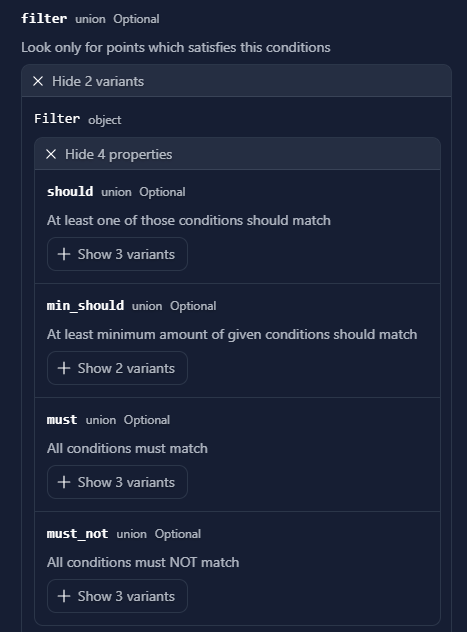
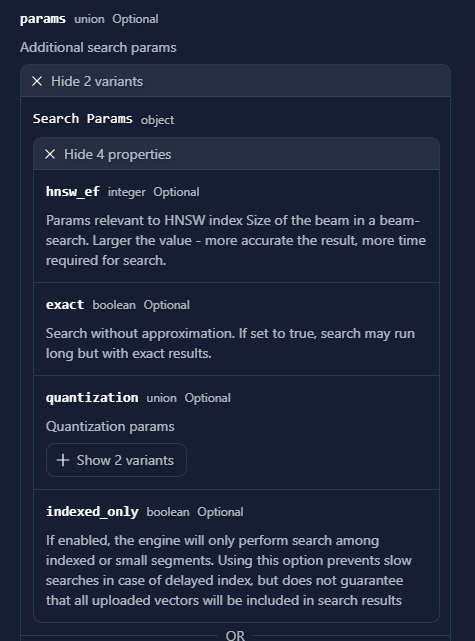

In [277]:
target_label = "宽表"
filter_=dm.Filter(
        must=[
            FieldCondition(key="word", match=MatchValue(value=target_label)),
        ]
    )
#以逐页方式返回所有点
search_result = client.scroll(
    collection_name=collection_name,
    # scroll_filter={
    #     "must": [
    #         {
    #             "key": "word",
    #             "match": {
    #                 "value": target_label
    #             }
    #         }
    #     ]
    # },
    scroll_filter=filter_,
    with_vectors=True,
    with_payload=True,

    #order_by='df',
    limit=2  # 只获取一个匹配的结果
)
#search_result[0][0].vector
search_result

([Record(id=76880, payload={'行业': '先进制造', 'index': 76880, 'df': 6, 'word': '宽表', 'tf': 13}, vector=[-0.04335597902536392, 1.7791573554859497e-05, 0.11731202155351639, 0.09385939687490463, 0.03247273713350296, 0.07952266931533813, -0.0394255667924881, 0.043071579188108444, 0.11578206717967987, 0.1460943967103958, 0.024097424000501633, -0.023876409977674484, -0.022880032658576965, 0.04921729862689972, 0.14991797506809235, -0.08105181157588959, -0.07938890159130096, -0.11585227400064468, 0.10658716410398483, -0.0364251434803009, 0.00042274416773580015, -0.047234710305929184, -0.029309753328561783, -0.11469011753797531, 0.044194359332323074, 0.09112890809774399, 0.05955852195620537, 0.04247402027249336, 0.027541402727365494, -0.07694949209690094, 0.038220878690481186, -0.01592719927430153, -0.14118847250938416, -0.016231566667556763, 0.08347557485103607, 0.025836434215307236, 0.013524116016924381, 0.005080690141767263, 0.01431212853640318, -0.12376157194375992, -0.007254477124661207, -0.12

In [296]:
target_label = "宽表"
filter_=dm.Filter(
        must=[
            FieldCondition(key="word", match=MatchValue(value=target_label)),
            FieldCondition(key="行业",match=MatchValue(value="传统制造",),)
        ]
    )
#以逐页方式返回所有点
search_result = client.scroll(
    collection_name=collection_name,
    # scroll_filter={
    #     "must": [
    #         {
    #             "key": "word",
    #             "match": {
    #                 "value": target_label
    #             }
    #         }
    #     ]
    # },
    scroll_filter=filter_,
    with_vectors=True,
    with_payload=True,

    #order_by='df',
    limit=1  # 只获取一个匹配的结果
)
search_result 

([Record(id=419044, payload={'行业': '传统制造', 'df': 2, 'word': '宽表', 'index': 68921, 'tf': 9}, vector=[0.10179511457681656, -0.0023343442007899284, 0.02711455337703228, 0.03263173624873161, 0.04186317324638367, -0.07963865250349045, 0.016137216240167618, 0.08250651508569717, 0.01940610073506832, 0.02013571187853813, -0.022401168942451477, 0.03755269572138786, 0.037365563213825226, 0.03300650417804718, 0.023365497589111328, -0.02234816737473011, -0.11061055958271027, -0.00300019234418869, -0.12916159629821777, -0.0035580252297222614, -0.06286544352769852, 0.05668935552239418, 0.038385529071092606, -0.07111337780952454, 0.030702853575348854, -0.024842936545610428, 0.03863505274057388, -0.051889922469854355, -0.00042305010720156133, 0.014772722497582436, 0.016844265162944794, 0.03650450333952904, -0.10665281116962433, -0.1330958753824234, 0.08120319247245789, -0.06278689950704575, 0.015204368159174919, -0.0940684899687767, 0.09483395516872406, -0.09726271033287048, 0.01874113455414772, 0.046

In [286]:
filter_ = Filter(
    must=[
        FieldCondition(
            key="行业",
            match=MatchValue(
                value="传统制造",
            ),
        )
    ]
)
search_queries = [
    dm.SearchRequest(vector=query_vector, filter=filter_, limit=3,with_payload=True),
    dm.SearchRequest(vector=query_vector_1, filter=filter_, limit=3,with_payload=True),
]
client.search_batch(collection_name=collection_name, requests=search_queries)#根据向量相似性和给定的过滤条件,批量检索最接近的点

[[ScoredPoint(id=350123, version=71, score=1.0, payload={'行业': '传统制造', 'df': 190204, 'word': '所述', 'index': 0, 'tf': 946114}, vector=None, shard_key=None),
  ScoredPoint(id=350129, version=71, score=0.6807588934898376, payload={'行业': '传统制造', 'index': 6, 'word': '第一', 'df': 80116, 'tf': 287318}, vector=None, shard_key=None),
  ScoredPoint(id=350132, version=71, score=0.6131157279014587, payload={'行业': '传统制造', 'index': 9, 'df': 90757, 'word': '设有', 'tf': 220777}, vector=None, shard_key=None)],
 [ScoredPoint(id=350124, version=71, score=1.0000001192092896, payload={'行业': '传统制造', 'index': 1, 'word': '一种', 'df': 378375, 'tf': 695433}, vector=None, shard_key=None),
  ScoredPoint(id=350139, version=71, score=0.6030797958374023, payload={'行业': '传统制造', 'index': 16, 'df': 75209, 'word': '方法', 'tf': 183987}, vector=None, shard_key=None),
  ScoredPoint(id=350213, version=71, score=0.5520822405815125, payload={'行业': '传统制造', 'word': '属于', 'index': 90, 'df': 43288, 'tf': 43505}, vector=None, shard_ke

In [331]:
def most_similar_by_name(name, collection_name,mutch=[], exclude=[],topn=10, score_threshold=0.5):
    match_name=FieldCondition(key='word',match=MatchValue(value=name,),)
    match_not_name=[FieldCondition(key='word',match=MatchValue(value=w),) for w in exclude]
    scroll_filter = Filter(must=mutch+[match_name])
    scroll_result=client.scroll(collection_name=collection_name,
                                scroll_filter=scroll_filter,
                                with_vectors=True,
                                with_payload=True,
                                limit=1)  # 只获取一个匹配的结果
    #print(result_0)
    query_vector=scroll_result[0][0].vector
    
    query_filter=Filter(must=mutch,must_not=[match_name]+match_not_name)# 缩小查询范围 
    search_hit=client.search(collection_name=collection_name,
                            query_vector= query_vector,#tolist()
                            query_filter=query_filter,                     
                            limit=topn,
                            score_threshold=score_threshold,
                            search_params=SearchParams(exact=True,),  # Turns on the exact search mode               
                        )
    
    return [(p.payload['word'],p.score) for p in search_hit]

match_hy=[FieldCondition(key="行业",match=MatchValue(value="金融",),)]
most_similar_by_name('人工智能',collection_name,match_hy, topn=10)    

[('计算机领域', 0.687181830406189),
 ('计算机信息', 0.597895622253418),
 ('计算机技术', 0.5902829170227051),
 ('网络安全', 0.5733133554458618),
 ('数据分析', 0.5690364241600037),
 ('方法', 0.5622820854187012),
 ('程序设计', 0.5606061816215515),
 ('图像处理', 0.5571784377098083),
 ('训练方法', 0.5506466627120972),
 ('领域', 0.5487185120582581)]

In [440]:
%%time
def name_to_ids(names,collection_name,mutch=[]):
    ret={}
    for w in names:
        match_name=FieldCondition(key='word',match=MatchValue(value=w),)
        scroll_filter = Filter(must=mutch+[match_name])
        scroll_result=client.scroll(collection_name=collection_name,
                            scroll_filter=scroll_filter,
                            with_payload=True,
                            #with_vectors=True,        
                            limit=1) 
        if len(scroll_result):
            ret[w]=scroll_result[0][0].id
    return ret
name_to_ids(['方法','人工智能'],collection_name,match_hy)    

CPU times: total: 0 ns
Wall time: 3.04 s


{'方法': 528399, '人工智能': 528742}

In [74]:
5 in range(1,500)

True

In [441]:
%%time
# filters = {
#     "should": [
#         {
#             "key": "label",
#             "match": {
#                 "value": label
#             }
#         } for label in target_labels
#     ]
# }
def name_to_ids(names,collection_name,mutch=[]):
    shoulds=[FieldCondition(key='word',match=MatchValue(value=w)) for w in names]
    scroll_filter = Filter(must=mutch,should=shoulds)

    scroll_result=client.scroll(collection_name=collection_name,
                    scroll_filter=scroll_filter,
                    with_payload=True,
                    #with_vectors=True,        
                    limit=len(names)) 
    
    return {i.payload['word']:i.id for i in scroll_result[0]}
name_to_ids(['方法','人工智能'],collection_name,match_hy)   

CPU times: total: 0 ns
Wall time: 3.09 s


{'方法': 528399, '人工智能': 528742}

In [393]:
client.count(collection_name=collection_name).count

557527

In [ ]:
#os.environ["QDRANT_API_KEY"] = "your-api-key"

In [396]:
# [(i.id,i.payload['word'])i.payload['行业']) for i in client.retrieve(collection_name=collection_name,ids=range(527))]
hy_name_id={}
for i in client.retrieve(collection_name=collection_name,ids=range(500)):
    prev=hy_name_id.get(i.payload['行业'],[])
    prev.append((i.id,i.payload['word']))
    hy_name_id[i.payload['行业']]=prev
len(hy_name_id)

1

In [350]:
client.retrieve(collection_name=collection_name,ids=[528399,528742],with_vectors=True)

[Record(id=528399, payload={'行业': '金融', 'df': 44783, 'word': '方法', 'index': 0, 'tf': 126859}, vector=[0.022369984537363052, -0.07480421662330627, -0.0395512729883194, 0.006151298061013222, 0.013950595632195473, -0.1468721479177475, 0.08044766634702682, -0.15183359384536743, -0.023574071004986763, -0.029082858934998512, 0.034255221486091614, 0.050116684287786484, -0.05691058933734894, -0.04151081666350365, 0.08291137963533401, 0.009235695004463196, -0.06400235742330551, 0.021076418459415436, -0.03143550083041191, -0.07538993656635284, 0.016964999958872795, 0.08818458020687103, -0.07311038672924042, -0.029940418899059296, -0.054906267672777176, 0.0446973480284214, -0.1217559427022934, -0.019872019067406654, -0.14293193817138672, 0.08317241817712784, -0.024319307878613472, 0.006911531090736389, 0.10258151590824127, -0.028731796890497208, -0.11528920382261276, 0.05186084285378456, 0.04382568597793579, 0.04572909325361252, 0.000665533822029829, 0.09283336251974106, 0.037528716027736664, 0.0

In [404]:
def most_similar_by_ids(ids, collection_name,mutch=[], exclude=[], topn=10):
    id_record=client.retrieve(collection_name=collection_name,ids=ids,with_vectors=True)
    
    names=[p.payload['word'] for p in id_record]
    match_not_name=[FieldCondition(key='word',match=MatchValue(value=w),) for w in names+exclude]
    query_filter=Filter(must=mutch,must_not=match_not_name)# 缩小查询范围 
   
    search_queries = [dm.SearchRequest(vector=p.vector, filter=query_filter, limit=topn,with_payload=True)
        for p in id_record]

    search_hit=client.search_batch(collection_name=collection_name,requests=search_queries)#ScoredPoint
    return [(id,name,[(p.payload['word'],p.score) for p in hit]) for id,name,hit in zip(ids,names,search_hit)]#[:topn]
    
most_similar_by_ids([528399,528742], collection_name, match_hy, exclude=['可读','装置','一种'], topn=10)  #[(p.payload['word'],p.score) for p in search_hit]

[(528399,
  '方法',
  [('计算机', 0.6264501214027405),
   ('识别方法', 0.6170319318771362),
   ('测试方法', 0.6153174638748169),
   ('存储介质', 0.5891509056091309),
   ('训练方法', 0.5817789435386658),
   ('分析方法', 0.5717079043388367),
   ('查询方法', 0.5560289025306702),
   ('信息处理', 0.5362227559089661),
   ('电子设备', 0.5226714015007019),
   ('计算方法', 0.5108342170715332)]),
 (528742,
  '人工智能',
  [('计算机领域', 0.687181830406189),
   ('计算机信息', 0.597895622253418),
   ('计算机技术', 0.5902829170227051),
   ('网络安全', 0.5733133554458618),
   ('数据分析', 0.5690364241600037),
   ('程序设计', 0.5606061816215515),
   ('图像处理', 0.5571784377098083),
   ('训练方法', 0.5506466627120972),
   ('领域', 0.5487185120582581),
   ('信息技术', 0.5463539958000183)])]

In [430]:
def SimilarByIds(ids, collection_name,mutch=[], exclude=[], topn=10, duplicate=0, score_threshold=0.5):
    id_record=client.retrieve(collection_name=collection_name,ids=ids,with_vectors=True)
    
    names=[p.payload['word'] for p in id_record]
    match_not_name=[FieldCondition(key='word',match=MatchValue(value=w),) for w in names+exclude]
    query_filter=Filter(must=mutch,must_not=match_not_name)# 缩小查询范围 

    search_queries = [dm.SearchRequest(vector=p.vector, filter=query_filter, limit=topn * len(names),with_payload=True)
        for p in id_record]

    search_hit=client.search_batch(collection_name=collection_name,requests=search_queries)#ScoredPoint
    similar_next = {}  # 数据格式:{co:[(next,val)*topn]}
    if duplicate==0:
        similar_next = {name:[(p.payload['word'],p.score) for p in hit[:topn]] for name,hit in zip(names,search_hit)}
        #return [(name,[(p.payload['word'],p.score) for p in hit[:topn]]) for name,hit in zip(names,search_hit)]

    if duplicate == 1: 
        for name,hit in zip(names,search_hit):
            y = [(p.payload['word'],p.score) for p in hit]
            y2=[_[0] for x in similar_next.values() for _ in x]
            similar_next[name] = [y3 for y3 in y if y3[0] not in y2][:topn]
    
    if duplicate == 2:  # 各自排序后,由下一节点各自选最近的上节点,最后由上节点各自匹配重复关系
        similar_with = {}
        for name,hit in zip(names,search_hit):
            y = [(p.payload['word'],p.score) for p in hit]
            for z in y:
                if z[0] not in similar_with or z[1] > similar_with[z[0]][1]:  # 对关系去重选最大的,反向选择
                    similar_with[z[0]] = (name, z[1])
        for y, x in similar_with.items():
            similar_next[x[0]] = sorted(similar_next.get(x[0], []) + [(y, x[1])], key=lambda z: z[1], reverse=True)[:topn]

    if duplicate == 3:
        similar_sort=sorted([(name,p.payload['word'], p.score) for name,hit in zip(names,search_hit) for p in hit],key=lambda x:x[2],reverse=True)
        print(len(similar_sort))
        pos = [] 
        for ix,iy,v in similar_sort:
            y = [p[1] for p in pos]
            x = [p[0] for p in pos if p[0] == ix]
            if len(x) < topn and iy not in y:
                pos.append((ix,iy)) 
                similar_next[ix] = similar_next.get(ix, []) + [(iy, v)]


    print(similar_next)
    return [(w, similar_next[w]) for w in names if w in similar_next] 

SimilarByIds([528399,528742], collection_name,match_hy,exclude=['可读','装置','一种'], topn=10,  duplicate=0)    

{'方法': [('计算机', 0.6264501214027405), ('识别方法', 0.6170319318771362), ('测试方法', 0.6153174638748169), ('存储介质', 0.5891509056091309), ('训练方法', 0.5817789435386658), ('分析方法', 0.5717079043388367), ('查询方法', 0.5560289025306702), ('信息处理', 0.5362227559089661), ('电子设备', 0.5226714015007019), ('计算方法', 0.5108342170715332)], '人工智能': [('计算机领域', 0.687181830406189), ('计算机信息', 0.597895622253418), ('计算机技术', 0.5902829170227051), ('网络安全', 0.5733133554458618), ('数据分析', 0.5690364241600037), ('程序设计', 0.5606061816215515), ('图像处理', 0.5571784377098083), ('训练方法', 0.5506466627120972), ('领域', 0.5487185120582581), ('信息技术', 0.5463539958000183)]}


[('方法',
  [('计算机', 0.6264501214027405),
   ('识别方法', 0.6170319318771362),
   ('测试方法', 0.6153174638748169),
   ('存储介质', 0.5891509056091309),
   ('训练方法', 0.5817789435386658),
   ('分析方法', 0.5717079043388367),
   ('查询方法', 0.5560289025306702),
   ('信息处理', 0.5362227559089661),
   ('电子设备', 0.5226714015007019),
   ('计算方法', 0.5108342170715332)]),
 ('人工智能',
  [('计算机领域', 0.687181830406189),
   ('计算机信息', 0.597895622253418),
   ('计算机技术', 0.5902829170227051),
   ('网络安全', 0.5733133554458618),
   ('数据分析', 0.5690364241600037),
   ('程序设计', 0.5606061816215515),
   ('图像处理', 0.5571784377098083),
   ('训练方法', 0.5506466627120972),
   ('领域', 0.5487185120582581),
   ('信息技术', 0.5463539958000183)])]

In [466]:
#需要记忆ID
class VDB_Similar:
    client=None
    collection_name=''
    match_first=None
    name_ids={}#unique,记忆
    
    def __init__(self,client,collection_name,match_first):
        self.client=client
        self.collection_name=collection_name
        self.match_first=match_first


    def get_ids(self,names):  
        finds=set(names)-self.name_ids.keys()
        if len(finds):
            shoulds=[FieldCondition(key='word',match=MatchValue(value=w)) for w in finds]
            scroll_filter = Filter(must=self.match_first,should=shoulds)
        
            scroll_result=self.client.scroll(collection_name=self.collection_name,
                            scroll_filter=scroll_filter,
                            with_payload=True,
                            #with_vectors=True,        
                            limit=len(finds)) 
            
            self.name_ids.update({i.payload['word']:i.id for i in scroll_result[0]})
            
        return [self.name_ids[n] for n in names if n in self.name_ids]



    def SimilarByNames(self, names, exclude=[], topn=10, duplicate=0, score_threshold=0.5):
        ids=self.get_ids(names)
        id_record=self.client.retrieve(collection_name=self.collection_name,ids=ids,with_vectors=True)
        
        names=[p.payload['word'] for p in id_record]
        match_not_name=[FieldCondition(key='word',match=MatchValue(value=w),) for w in names+exclude]
        query_filter=Filter(must=self.match_first,must_not=match_not_name)# 缩小查询范围 
    
        search_queries = [dm.SearchRequest(vector=p.vector, filter=query_filter, limit=topn * len(names),with_payload=True,score_threshold=score_threshold)
            for p in id_record]
    
        search_hit=self.client.search_batch(collection_name=self.collection_name,requests=search_queries)#ScoredPoint
        self.name_ids.update({p.payload['word']:p.id for hit in search_hit for p in hit})
        
        similar_next = {}  # 数据格式:{co:[(next,val)*topn]}
        if duplicate==0:
            similar_next = {name:[(p.payload['word'],p.score) for p in hit[:topn]] for name,hit in zip(names,search_hit)}
            #return [(name,[(p.payload['word'],p.score) for p in hit[:topn]]) for name,hit in zip(names,search_hit)]
    
        if duplicate == 1: 
            for name,hit in zip(names,search_hit):
                y = [(p.payload['word'],p.score) for p in hit]
                y2=[_[0] for x in similar_next.values() for _ in x]
                similar_next[name] = [y3 for y3 in y if y3[0] not in y2][:topn]
        
        if duplicate == 2:  # 各自排序后,由下一节点各自选最近的上节点,最后由上节点各自匹配重复关系
            similar_with = {}
            for name,hit in zip(names,search_hit):
                y = [(p.payload['word'],p.score) for p in hit]
                for z in y:
                    if z[0] not in similar_with or z[1] > similar_with[z[0]][1]:  # 对关系去重选最大的,反向选择
                        similar_with[z[0]] = (name, z[1])
            for y, x in similar_with.items():
                similar_next[x[0]] = sorted(similar_next.get(x[0], []) + [(y, x[1])], key=lambda z: z[1], reverse=True)[:topn]
    
        if duplicate == 3:
            similar_sort=sorted([(name,p.payload['word'], p.score) for name,hit in zip(names,search_hit) for p in hit],key=lambda x:x[2],reverse=True)
            print(len(similar_sort))
            pos = [] 
            for ix,iy,v in similar_sort:
                y = [p[1] for p in pos]
                x = [p[0] for p in pos if p[0] == ix]
                if len(x) < topn and iy not in y:
                    pos.append((ix,iy)) 
                    similar_next[ix] = similar_next.get(ix, []) + [(iy, v)]
    
        #print(similar_next)
        return [(w, similar_next[w]) for w in names if w in similar_next] 

match_first=[FieldCondition(key="行业",match=MatchValue(value=k,),) for k in ['金融']]    
vdbs=VDB_Similar(client,collection_name,match_first)  

In [463]:
vdbs.name_ids

{'电子设备': 528454,
 '计算机': 528527,
 '训练方法': 528807,
 '电子装置': 530199,
 '计算机设备': 528593,
 '装置': 528403,
 '方法': 528399,
 '可读': 528679,
 '设备': 528416,
 '一种': 528404,
 '计算机技术': 528797,
 '处理器': 529035,
 '信息处理': 528815,
 '终端设备': 528665,
 '人工智能': 528742,
 '系统': 528410,
 '识别方法': 528708,
 '通用报表': 556091,
 '测试中心': 552040,
 '计算机领域': 531228,
 '数据检索': 531487,
 '测试方法': 528759,
 '套环': 553852,
 '图像处理': 529420,
 '查询方法': 528992,
 '报端': 545851,
 '领域': 528476,
 '计算机信息': 534227,
 '数据管理': 529391,
 'cgra': 556513,
 '文本处理': 530368,
 '数据处理': 528472,
 '公开': 528420,
 '存储介质': 528417,
 '计算方法': 529435,
 '集成型': 555271,
 '编码方法': 533255,
 '分析方法': 529007,
 '失性': 531574,
 '计算机系统': 530416,
 '科技': 529032,
 '转换方法': 529935,
 '人聚类': 539821,
 '图像识别': 529427,
 '存取方法': 538082,
 '识别系统': 530649,
 '声纹识别': 530716,
 '人机对话': 533515,
 '代码生成': 529991,
 '视频分类': 535516,
 '合成': 529143,
 '校正方法': 534204,
 '消歧': 531945,
 '椭球': 553582,
 'moa': 551876}

In [475]:
vdbs.SimilarByNames(['计算机','训练方法','电子设备'], exclude=[], topn=3, duplicate=3, score_threshold=0.3)

27


[('计算机',
  [('可读', 0.7952480912208557),
   ('方法', 0.6264501214027405),
   ('装置', 0.6036657094955444)]),
 ('训练方法',
  [('文本处理', 0.6595162749290466),
   ('识别方法', 0.6527575254440308),
   ('图像处理', 0.6019161343574524)]),
 ('电子设备',
  [('电子装置', 0.6317121386528015),
   ('计算机设备', 0.6143226623535156),
   ('设备', 0.4685496389865875)])]

In [280]:
query_vector_1=client.retrieve(collection_name=collection_name,ids=[350124],with_vectors=True)[0].vector

In [293]:
#client.retrieve(collection_name=collection_name,ids=range(350123],528399)
query_vector=client.retrieve(collection_name=collection_name,ids=[350123],with_vectors=True)[0].vector
hits = client.search(
    collection_name=collection_name,
    query_vector=query_vector,#tolist()
    limit=10,  # Return 5 closest points
    score_threshold=0.5
)
hits

[ScoredPoint(id=350123, version=71, score=1.0, payload={'行业': '传统制造', 'word': '所述', 'index': 0, 'df': 190204, 'tf': 946114}, vector=None, shard_key=None),
 ScoredPoint(id=350129, version=71, score=0.6807588934898376, payload={'行业': '传统制造', 'df': 80116, 'index': 6, 'word': '第一', 'tf': 287318}, vector=None, shard_key=None),
 ScoredPoint(id=350132, version=71, score=0.6131157279014587, payload={'行业': '传统制造', 'index': 9, 'df': 90757, 'word': '设有', 'tf': 220777}, vector=None, shard_key=None),
 ScoredPoint(id=350476, version=71, score=0.6012088060379028, payload={'行业': '传统制造', 'word': '设于', 'index': 353, 'df': 10913, 'tf': 14661}, vector=None, shard_key=None),
 ScoredPoint(id=350175, version=71, score=0.5982853770256042, payload={'行业': '传统制造', 'df': 44865, 'word': '位于', 'index': 52, 'tf': 63957}, vector=None, shard_key=None),
 ScoredPoint(id=350133, version=71, score=0.5925279855728149, payload={'行业': '传统制造', 'df': 68223, 'word': '第二', 'index': 10, 'tf': 218523}, vector=None, shard_key=None)

In [214]:
res=client.search_groups(collection_name=collection_name,query_vector=query_vector,    
                     group_by='行业',
                    limit=8,
                    group_size=2,
                )
res

GroupsResult(groups=[PointGroup(hits=[ScoredPoint(id=350123, version=71, score=1.0, payload={'行业': '传统制造', 'df': 190204, 'index': 0, 'word': '所述', 'tf': 946114}, vector=None, shard_key=None), ScoredPoint(id=350129, version=71, score=0.6807588934898376, payload={'行业': '传统制造', 'word': '第一', 'index': 6, 'df': 80116, 'tf': 287318}, vector=None, shard_key=None)], id='传统制造', lookup=None), PointGroup(hits=[ScoredPoint(id=157552, version=31, score=0.28076833486557007, payload={'行业': '先进制造', 'index': 157552, 'word': 'qualnet', 'df': 1, 'tf': 3}, vector=None, shard_key=None), ScoredPoint(id=61843, version=12, score=0.24718166887760162, payload={'行业': '先进制造', 'df': 7, 'word': '交握', 'index': 61843, 'tf': 20}, vector=None, shard_key=None)], id='先进制造', lookup=None), PointGroup(hits=[ScoredPoint(id=529535, version=107, score=0.24834837019443512, payload={'行业': '金融', 'index': 1136, 'word': '数据仓库', 'df': 191, 'tf': 483}, vector=None, shard_key=None), ScoredPoint(id=530891, version=107, score=0.23987647

In [215]:
for x in res.groups:
    print(x.id,x.hits)

传统制造 [ScoredPoint(id=350123, version=71, score=1.0, payload={'行业': '传统制造', 'df': 190204, 'index': 0, 'word': '所述', 'tf': 946114}, vector=None, shard_key=None), ScoredPoint(id=350129, version=71, score=0.6807588934898376, payload={'行业': '传统制造', 'word': '第一', 'index': 6, 'df': 80116, 'tf': 287318}, vector=None, shard_key=None)]
先进制造 [ScoredPoint(id=157552, version=31, score=0.28076833486557007, payload={'行业': '先进制造', 'index': 157552, 'word': 'qualnet', 'df': 1, 'tf': 3}, vector=None, shard_key=None), ScoredPoint(id=61843, version=12, score=0.24718166887760162, payload={'行业': '先进制造', 'df': 7, 'word': '交握', 'index': 61843, 'tf': 20}, vector=None, shard_key=None)]
金融 [ScoredPoint(id=529535, version=107, score=0.24834837019443512, payload={'行业': '金融', 'index': 1136, 'word': '数据仓库', 'df': 191, 'tf': 483}, vector=None, shard_key=None), ScoredPoint(id=530891, version=107, score=0.23987647891044617, payload={'行业': '金融', 'word': '宽表', 'index': 2492, 'df': 49, 'tf': 144}, vector=None, shard_key=No

In [217]:
filter_=Filter(must=[FieldCondition(key="word", match=MatchValue(value='电子备')),])
#client.retrieve(collection_name=collection_name,count_filter=filter_,with_vectors=True)

In [3]:
patent_co=pd.read_csv('E:\Documents\Jupyter/data/融资公司专利2024.csv',index_col=0)

In [5]:
bridge=pd.read_csv('data\patent_bridge.csv',index_col=0)
patent_co.shape,bridge.shape

((1897517, 28), (13656939, 7))

In [8]:
bridge.columns

Index(['序号', '公开（公告）号', '申请号', '申请日', '申请人', '标题 (中文)', 'table'], dtype='object')

In [10]:
patent_co.columns

Index(['Co', '序号', '标题 (中文)', '摘要 (中文)', '申请人', '申请日', '申请号', '首次公开日',
       '公开（公告）号', '专利类型', '专利有效性', '公开国别', 'IPC主分类', 'IPC', '申请人类型', '发明人',
       '发明人数量', '简单同族', '扩展同族', '简单同族个数', '引证专利', '引证科技文献', '引证次数', '被引证次数',
       '申请人数量', '许可次数', '转让次数', '权利要求数量'],
      dtype='object')

In [7]:
bridge['公开（公告）号'].nunique()

9338399

In [19]:
bridge.head()

,序号,公开（公告）号,申请号,申请日,申请人,标题 (中文),table
0,1,CN114587079A,CN202210229642.3,2022-03-09,江西晶亮实业有限公司,一种便携式可移动的靠背课椅,patent_incopat_202101_202211
1,2,CN114587081A,CN202210023433.3,2022-01-10,皖西学院,一种面条生产用的组合式储物柜,patent_incopat_202101_202211
2,3,CN114587082A,CN202210242336.3,2022-03-13,尚品本色智能家居有限公司,一种自动平衡服装数量的衣柜,patent_incopat_202101_202211
3,4,CN114587083A,CN202210058364.X,2022-01-19,宁波工程学院,一种可自动取放的智能鞋柜,patent_incopat_202101_202211
4,5,CN114587084A,CN202210133941.7,2022-02-14,江苏诺德物流设备制造有限公司,一种轻便的可移动密集架及其使用方法,patent_incopat_202101_202211


In [9]:
bridge['申请号'].nunique()

8679874

In [28]:
bridge = bridge.drop_duplicates(subset=['公开（公告）号', '申请号'])
bridge.shape

(9338426, 7)

In [29]:
%%time
result = pd.merge(patent_co,bridge[['公开（公告）号', '申请号','table']],on=['公开（公告）号', '申请号'],how='left')

CPU times: total: 20.1 s
Wall time: 20.1 s


In [30]:
result.shape

(1897517, 29)

In [31]:
result.count()

Co         1897517
序号         1897517
标题 (中文)    1897517
摘要 (中文)    1891722
申请人        1897517
申请日        1897517
申请号        1897517
首次公开日      1897444
公开（公告）号    1897517
专利类型       1897517
专利有效性      1897517
公开国别       1897517
IPC主分类     1749833
IPC        1749840
申请人类型      1890288
发明人        1897146
发明人数量      1897069
简单同族       1897517
扩展同族       1897517
简单同族个数     1897517
引证专利        776346
引证科技文献      177648
引证次数        776346
被引证次数       609868
申请人数量      1897517
许可次数         12371
转让次数        102940
权利要求数量     1745559
table      1897517
dtype: int64

In [32]:
bridge.to_csv('data\patent_bridge.csv')
result.to_csv('data\融资公司专利2024.csv')

In [ ]:
# patent_co.set_index(['序号', '公开（公告）号', '申请号', '申请日'], inplace=True)
# bridge.set_index(['序号', '公开（公告）号', '申请号', '申请日'], inplace=True)
# result = patent_co.join(bridge[['table']], how='left')
# result.reset_index(inplace=True)

In [7]:
patent_co.shape,word_tf_df.shape,wd_data.shape

((1897517, 29), (491868, 2), (1889962, 2))

In [18]:
set(patent_co.序号)^set(wd_data.序号)

set()

In [37]:
bd_word=pd.read_excel('data/百度输入法词库1.xlsx',index_col=0)
bd_word.index

Index(['财经', '法律', '计算机', '数学', '物理', '学科', '专利审查', '专利法实务', 'IT', '机械工程',
       '考古', '生物', '政治', '冶金', '医学词汇', '化工', '知识产权', '农业', '气象', '化学', '哲学',
       '军事', '股票基金', '常用医药'],
      dtype='object')

In [40]:
s_bd_word=bd_word['词库'].str.split(',').explode()
s_bd_word=pd.Series(s_bd_word.index,index=s_bd_word.values)
s_bd_word=s_bd_word.groupby(s_bd_word.index).apply(lambda x: ','.join(set(x)))
bd_flag=s_bd_word.to_dict()
len(bd_flag)

94188

In [43]:
bd_flag['3D']

'IT'

In [36]:
import jieba.posseg
jieba.initialize()
jieba.load_userdict('data\\专利分词词库.txt')#

In [26]:
word_tf_df.dtypes

tf    int64
df    int64
dtype: object

In [32]:
word_tf_df=word_tf_df[~word_tf_df.index.isna()]

In [33]:
word_tf_df.index.isna().sum()

0

In [38]:
%%time
word_tf_df['flag']=word_tf_df.index.map(lambda x: ','.join([i.flag for i in jieba.posseg.cut(x)]))

CPU times: total: 3min 51s
Wall time: 3min 51s


In [46]:
%%time
word_tf_df['baidu']=word_tf_df.index.map(bd_flag)

CPU times: total: 203 ms
Wall time: 195 ms


In [53]:
wd_data['词语'].isna().sum()

5776

In [54]:
wd_data=wd_data[~wd_data['词语'].isna()]

In [62]:
%%time
wd_data['count']=wd_data['词语'].apply(Counter)
wd_data['count']

CPU times: total: 22.9 s
Wall time: 22.9 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0          {'竖式': 2, '烧结': 3, '冷却': 4, '一种': 1, '具有': 2, ...
1          {'具有': 3, '抗静电': 2, '轻垢': 2, '液体': 2, '洗衣': 2,...
2          {'麦白': 4, '霉素': 5, '胃溶片': 4, '生产工艺': 3, '技术': ...
3                      {'药品': 1, '包装盒': 1, '省略': 1, '视图': 1}
4          {'变幅': 4, '摇头': 5, '电风扇': 2, '一种': 1, '包括': 1,...
                                 ...                        
1889957    {'机器人': 5, '标定': 3, '方法': 3, '系统': 2, '涉及': 2,...
1889958    {'一种': 2, '多普勒': 3, '激光': 3, '测风': 3, '雷达': 3,...
1889959    {'一种': 2, '晶圆': 2, '激光': 6, '开槽': 5, '装置': 2, ...
1889960    {'一种': 2, '微型': 2, '塑料件': 3, '激光': 3, '焊接': 8,...
1889961    {'可拆卸': 2, '电池': 3, '模块': 3, '公开': 1, '涉及': 1,...
Name: count, Length: 1884186, dtype: object

In [65]:
wd_data['count'].apply(lambda x:x.get('数据')).dropna().sort_values(ascending=False)

264770     33.0
264774     33.0
1167399    31.0
1167405    31.0
459283     31.0
           ... 
537575      1.0
537574      1.0
1426616     1.0
537573      1.0
251         1.0
Name: count, Length: 157367, dtype: float64

In [70]:
patent_co.columns

Index(['Co', '序号', '标题 (中文)', '摘要 (中文)', '申请人', '申请日', '申请号', '首次公开日',
       '公开（公告）号', '专利类型', '专利有效性', '公开国别', 'IPC主分类', 'IPC', '申请人类型', '发明人',
       '发明人数量', '简单同族', '扩展同族', '简单同族个数', '引证专利', '引证科技文献', '引证次数', '被引证次数',
       '申请人数量', '许可次数', '转让次数', '权利要求数量', 'table'],
      dtype='object')

In [73]:
patent_co['序号'].nunique(),len(patent_co)

(1889962, 1897517)

In [76]:
wd_data_1=pd.merge(wd_data,patent_co[['序号','标题 (中文)', '摘要 (中文)','申请号','公开（公告）号']].drop_duplicates(subset=['序号']),
         on='序号',how='left')

In [79]:
wd_data_1.shape,len(wd_data)

((1884186, 7), 1884186)

In [88]:
wd_data_1.index

RangeIndex(start=0, stop=1884186, step=1)

In [80]:
def get_max_count(word,counter):
    series = counter.apply(lambda x:x.get(word))
    max_index = series.idxmax()
    return series[max_index],max_index
    # sorted_series=wd_data_count.apply(lambda x:x.get(word)).sort_values(ascending=False)
    # return sorted_series.iloc[0],sorted_series.index[0]

get_max_count('数据',wd_data_1['count'])

(33.0, 261660)

In [82]:
wd_data_1['摘要 (中文)'].iloc[261660].count('数据')

32

In [93]:
wd_data_1.loc[261660,'公开（公告）号']

'CN104967639B'

In [94]:
def get_max_count(word,doc_counter):
    s1 = doc_counter['count'].apply(lambda x:x.get(word))
    max_index = s1.idxmax()
    max_values = s1[max_index] #int(s1.max())
    max_values_index = s1.index[s1.values == max_values] #.tolist()
    max_values_2 = max_values
    doc=doc_counter.iloc[max_values_index]['摘要 (中文)'].dropna()
    try:
        s2 =  doc.str.count(word)
        if len(max_values_index)>1:
            max_index=s2.idxmax()
        max_values_2 = s2[max_index]
    except:
        print(word,doc)
        pass
    return max_values,max_values_2,doc_counter.iloc[max_index]['公开（公告）号']
    
get_max_count('数据',wd_data_1)

(33.0, 32, 'CN104967639B')

In [ ]:
# %%time
# word_tf_df['cut_max_count'],word_tf_df['doc_max_count'],word_tf_df['公开（公告）号']=zip(*word_tf_df.index.map(lambda x: get_max_count(x,wd_data_1)))

c++ 1222459    本发明提供了一种C++模块接口的调用方法及装置，在预设存储结构中定义与目标C++模块接口具有...
Name: 摘要 (中文), dtype: object
++ 1631584    本申请提供了一种MOS器件及其制作方法和应用。MOS器件包括P‑base区、P++区和衬底；...
Name: 摘要 (中文), dtype: object


In [110]:
batch_size=50000
batches = np.array_split(word_tf_df.index, np.ceil(len(word_tf_df.index) / batch_size))

In [113]:
sum(len(b) for b in batches),len(word_tf_df)

(491866, 491866)

In [116]:
results = []
for i,batch in enumerate(batches):
    print(f"Processing batch: {i}")
    batch_results = word_tf_df.loc[batch].index.map(lambda x: get_max_count(x, wd_data_1))
    word_tf_df.loc[batch, ['cut_max_count', 'doc_max_count', '公开（公告）号']] = list(batch_results)
    results.append(word_tf_df.loc[batch])

processed_df = pd.concat(results)

Processing batch: 0


KeyboardInterrupt: 

In [117]:
word_tf_df.columns

Index(['tf', 'df', 'flag', 'baidu', 'cut_max_count', 'doc_max_count',
       '公开（公告）号'],
      dtype='object')

In [120]:
word_tf_df['公开（公告）号'].count()

49187

In [103]:
word_tf_df.to_excel('data/patent_word_source_188.xlsx')

In [122]:
def get_max_count(word,counter):
    series = counter['count'].apply(lambda x:x.get(word))
    max_index = series.idxmax()
    return series[max_index],counter.iloc[max_index]['公开（公告）号']

get_max_count('数据',wd_data_1)

(33.0, 'CN104967639B')

In [124]:
mask=word_tf_df['公开（公告）号'].isna()

In [ ]:
%%time
word_tf_df.loc[mask,'cut_max_count'],word_tf_df.loc[mask,'公开（公告）号']=zip(*word_tf_df[mask].index.map(lambda x: get_max_count(x,wd_data_1)))
word_tf_df.to_excel('data/patent_word_source_188.xlsx')

In [ ]:
word_tf_df.columns

In [42]:
co=pd.read_excel('data\公司融资变量2_20240301.xlsx')
co

,Unnamed: 0,公司序号,公司简称,工商全称,成立时间,公司简介,省,市,行业,子行业,...,金额,币种,等值人民币（万）,投资机构,VC_Amount,Cum_invset,Age,VC-num,有披露,上市Days
0,0,0,SciXair空气净化器,天津蔚蓝科技有限公司,2013-9,SciXair是一家空气净化器开发设计和销售服务商，目前主打产品为SciXair C1科学空...,北京,朝阳区,传统制造,环保,...,未透露,人民币,2000.0,国金投资|,7.601402,1.0,2.0,1.0,0.0,NaN
1,1,1,iKair家庭环境管家,北京超感时空科技有限公司,2013-8,iKair家庭环境管家是一个专注于家庭室内环境监测的软硬件服务平台，提供模块式的检测仪帮助用...,北京,海淀区,传统制造,环保,...,未透露,人民币,3000.0,IDG资本|,8.006701,2.0,3.0,1.0,0.0,NaN
2,2,1,iKair家庭环境管家,北京超感时空科技有限公司,2013-8,iKair家庭环境管家是一个专注于家庭室内环境监测的软硬件服务平台，提供模块式的检测仪帮助用...,北京,海淀区,传统制造,环保,...,200,美元,1300.0,戈壁创投|,7.170888,1.0,1.0,1.0,1.0,NaN
3,3,2,云印技术,云印技术（深圳）有限公司,2013-10,云印技术专注包装产业的数字化商业价值探索，通过云计算、大数据、机器智能与包装工业的融合，以2...,广东,深圳,传统制造,轻工制造,...,未透露,人民币,10000.0,东方精工|腾讯投资|山鹰投资|德屹资本|,9.210440,5.0,10.0,4.0,0.0,NaN
4,4,2,云印技术,云印技术（深圳）有限公司,2013-10,云印技术专注包装产业的数字化商业价值探索，通过云计算、大数据、机器智能与包装工业的融合，以2...,广东,深圳,传统制造,轻工制造,...,未透露,人民币,10000.0,山鹰投资|,9.210440,4.0,6.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47915,47915,25150,康迪医药,辽宁康迪医药有限公司,2010-4,康迪医药主要经营中药饮片、中药材、中成药、化学药制剂、生物制品（除疫苗）、生化药品、抗生素、...,辽宁,沈阳,医疗健康,生物技术和制药,...,未透露,人民币,2000.0,泓嘉基金|,7.601402,1.0,14.0,1.0,0.0,NaN
47916,47916,25151,光声制药,上海光声制药有限公司,2018-12,光声制药是一家创新型光敏剂及其相关产品研发商，致力于推动光/声动力治疗方式的发展，主要聚焦在...,上海,浦东新区,医疗健康,生物技术和制药,...,10000,人民币,10000.0,东方富海|,9.210440,1.0,6.0,1.0,1.0,NaN
47917,47917,25152,太希智能,杭州太希智能科技有限公司,2020-11,太希智能是一家外骨骼机器人制造商，专注于智能外骨骼机甲及双足机器人研发，致力于结合人工智能，...,浙江,杭州,医疗健康,医疗器械,...,未透露,人民币,100.0,浙大友创|,4.615121,1.0,4.0,1.0,0.0,NaN
47918,47918,25153,途深智合,上海途深智合人工智能科技有限公司,2023-3,途深智合是一家人工智能蛋白质设计服务商，致力于为客户提供通用、轻量、可控的蛋白质设计和生成式...,上海,闵行区,医疗健康,生物技术和制药,...,数百万,人民币,300.0,无锡光子芯谷|诚美创投|,5.707110,1.0,2.0,2.0,1.0,NaN


In [45]:
co=co[['工商全称','市']].drop_duplicates().dropna(subset='工商全称').reset_index(drop=True)

In [47]:
co.to_excel('data\企业区域.xlsx')